<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/SLEAP_plant_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SLEAPを利用した植物動態解析（未完）

メモ　ボトムアップの場合は
https://sleap.ai/notebooks/Training_and_inference_using_Google_Drive.html
1. !sleap-train multi_instance.json colab.pkg.slp
1. !sleap-track colab_demo.mp4 \
    --frames 0-200 \
    --tracking.tracker simple \
    -m colab_demo.bottomup

1. !sleap-inspect colab_demo.mp4.predictions.slp


SLEAPフレームワークを活用した植物の動態解析の論文

https://plantmethods.biomedcentral.com/articles/10.1186/s13007-022-00851-9#availability-of-data-and-materials

## 環境設定

2024年4月時点でSLLEAPはCUDA11.8にしか対応していない一方、google colaboratoryはCUDA12.2です。CUDAのダウングレードを先立って行います。下記の操作には5~10分かかります。

In [ ]:
!apt update && apt install cuda-11-8

In [ ]:
#!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]>=1.3.3"

## データセットダウンロード

In [3]:
!rm -r /content/SLEAPTrackingData
!wget -O SLEAPTrackingData.zip https://zenodo.org/records/5764169/files/SLEAPTrackingData.zip?download=1
!unzip -q SLEAPTrackingData.zip

rm: cannot remove '/content/SLEAPTrackingData': No such file or directory
--2024-04-20 10:13:07--  https://zenodo.org/records/5764169/files/SLEAPTrackingData.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92547452 (88M) [application/octet-stream]
Saving to: ‘SLEAPTrackingData.zip’

SLEAPTrackingData.z 100%[===================>]  88.26M  17.9MB/s    in 6.0s    

2024-04-20 10:13:14 (14.7 MB/s) - ‘SLEAPTrackingData.zip’ saved [92547452/92547452]



### データセットの確認
/content/SLEAPTrackingData/moviesに解析対象の動画が保存されています。

In [4]:
import os
movie_dir = "/content/SLEAPTrackingData/movies"
for file in os.listdir(movie_dir):
    print(file)

Arabidopsis_Phototrop_200915.avi
Arabidopsis_Gravitropism_200308.mp4
SunflowersTopView.avi
BeanTwiningLong.avi
Sunflower_Phototrop.avi


Arabidopsis_Gravitropism_200308.mp4以外はavi形式の動画ファイルです。colaboratoryで再生するため、ffmpegを利用して、aviをmp4変換します。**サイズ縮小などを行っているため、再生用途専用であり、解析には使わないこと。**

In [ ]:
import os

movie_dir = "/content/SLEAPTrackingData/movies"

# Ensure ffmpeg is installed
!pip install ffmpeg-python

for file in os.listdir(movie_dir):
    if os.path.splitext(file)[1] == ".avi":
        # Construct input and output file paths
        input_path = os.path.join(movie_dir, file)
        output_path = os.path.join(movie_dir, file[:-4] + ".mp4")

        # Convert AVI to MP4 with reduced bitrate, and ensure dimensions are divisible by 2
        !ffmpeg -i {input_path} -b:v 500k -vf "scale='320:trunc(ow/a/2)*2'" {output_path}

In [ ]:
from IPython.display import HTML, display
from base64 import b64encode
# Google Driveの共有リンク

for url in os.listdir(movie_dir):
    if os.path.splitext(url)[1] == ".mp4":
        print(url)
        video_path = os.path.join(movie_dir, url)
        video_data = open(video_path, "rb").read()
        # Determine the video MIME type based on the file extension
        file_ext = os.path.splitext(video_path)[1]
        if file_ext.lower() == '.mp4':
            mime_type = 'video/mp4'
        else:
            raise ValueError("Unsupported file format")

        # Encode video data for embedding
        video_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

        # Display video with HTML
        display(HTML(f"""<video width=400 controls><source src="{video_url}" type="{mime_type}">Your browser does not support the video tag.</video>"""))

## SLEAPモデルの訓練
- トップダウン
![topdown](https://sleap.ai/_images/topdown_approach.jpg)
- ボトムアップ
![botomup](https://sleap.ai/_images/bottomup_approach.jpg)


https://sleap.ai/tutorials/initial-training.html　より転載

In [7]:
label_slp_path = "SLEAPTrackingData/slp_Files/Sunflower_Topview_Leaf_20Labels.slp"
video_path = "SLEAPTrackingData/movies/SunflowersTopView.avi"
project_name = "sunflowerstopview20"

In [ ]:
!sleap-train baseline_medium_rf.bottomup.json {label_slp_path} --run_name {project_name} --video-paths {video_path}

In [9]:
output_path = os.path.join("models", project_name)
print(output_path)

models/sunflowerstopview20


In [10]:
!sleap-track {video_path} -m {output_path}

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Started inference at: 2024-04-20 11:07:59.421137
Args:
{
│   'data_path': 'SLEAPTrackingData/movies/SunflowersTopView.avi',
│   'models': ['models/sunflowerstopview20'],
│   'frames': '',
│   'only_labeled_frames': False,
│   'only_suggested_frames': False,
│   'output': None,
│   'no_empty_frames': False,
│   'verbosity': 'rich',
│   'video.dataset': None,
│   'video.input_format': 'channels_last',
│   'video.index': '',
│   'cpu': False,
│   'first_gpu': False,
│   'last_gpu': False,
│   'gpu': 'auto',
│   'max_edge_length_ratio': 0.25,
│   'dist_penalty_weight': 1.0,
│   'batch_size': 4,
│   'open_in_gui': False,
│   'peak_threshold': 0.2,
│   'max_instances': None,
│   'tracking.tracker': None,
│   'tracking.max_tracking': None,
│   'tracking.max_tracks': None,
│   'tracking.target_instance_count': None,
│   'trackin

In [11]:
predicted_slp_path = video_path + ".predictions.slp"
!sleap-inspect {predicted_slp_path}

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Labeled frames: 90
Tracks: 0
Video files:
  SLEAPTrackingData/movies/SunflowersTopView.avi
    labeled frames: 90
    labeled frames from 0 to 89
    user labeled frames: 0
    tracks: 1
    max instances in frame: 16
Total user labeled frames: 0

Provenance:
  model_paths: ['models/sunflowerstopview20/training_config.json']
  predictor: BottomUpPredictor
  sleap_version: 1.4.0
  platform: Linux-6.1.58+-x86_64-with-glibc2.35
  command: /usr/local/bin/sleap-track SLEAPTrackingData/movies/SunflowersTopView.avi -m models/sunflowerstopview20
  data_path: SLEAPTrackingData/movies/SunflowersTopView.avi
  output_path: SLEAPTrackingData/movies/SunflowersTopView.avi.predictions.slp
  total_elapsed: 17.387068510055542
  start_timestamp: 2024-04-20 11:07:59.421137
  finish_timestamp: 2024-04-20 11:08:16.808192
  args: {'data_path':

## Analysis Example

In [12]:
import sleap
# predicted_slp_path
labels = sleap.load_file(predicted_slp_path)

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


最終フレームだけ可視化してみましょう。

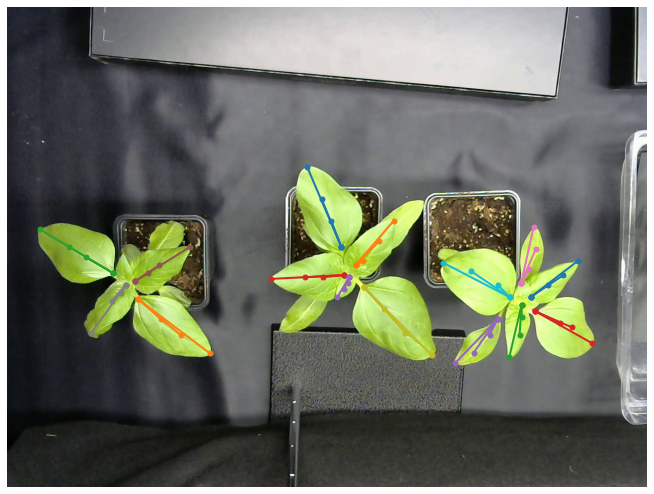

In [24]:
labels[-1].plot(scale=0.5)

動画として書き出します。


In [27]:
!sleap-render {predicted_slp_path}

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Saving config: /root/.sleap/1.4.0/preferences.yaml
Writing video with 90 frame images...
INFO:sleap.io.visuals:Chunks: 2, chunk size: 64
Finished 64 frames in 3.9 s, fps = 16, approx 1.6 s remaining
Finished 90 frames in 4.2 s, fps = 21, approx 0.0 s remaining
Done in 4.266681405999407 s, fps = 21.093677131236106.
Video saved as: SLEAPTrackingData/movies/SunflowersTopView.avi.predictions.slp.avi


mp4変換して再生します。

In [ ]:
movie_path = "SLEAPTrackingData/movies/SunflowersTopView.avi.predictions.slp.avi"
output_path = "SLEAPTrackingData/movies/SunflowersTopView.avi.predictions.slp.avi.mp4"
!ffmpeg -i {movie_path} -b:v 500k -vf "scale='320:trunc(ow/a/2)*2'" {output_path}

In [ ]:
video_data = open(output_path, "rb").read()
video_url = f"data:video/mp4;base64," + b64encode(video_data).decode()
display(HTML(f"""<video width=400 controls><source src="{video_url}" type="{mime_type}">Your browser does not support the video tag.</video>"""))

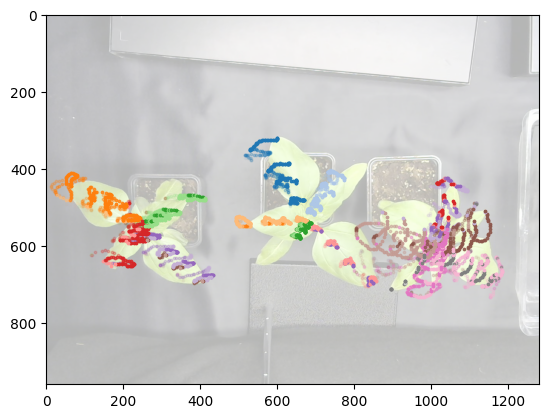

In [107]:
import numpy as np
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab20')

# 最終フレームの画像を表示
plt.imshow(labels[-1].image, alpha=0.3)

# フレームごとに検出座標を描画
for i, frame in enumerate(labels):
    instance_coords = [x.numpy() for x in frame.instances]
    # 葉ごとに描画scatter plotで点座標描画
    # 葉ごとに固有のcmapの色を指定して描画
    # フレームが進むにつれ、不透明度を増して描画
    for n, instance_coord in enumerate(instance_coords):
        plt.scatter(instance_coord[:,0], instance_coord[:,1], s=3, color=cmap(n), alpha=i/len(labels))

labelsから取り出すことのできるnumpy arrayは構造化されており、特定のキーポイントは特定のindexに対応します。

例えば特定の葉のみ描画したい場合は

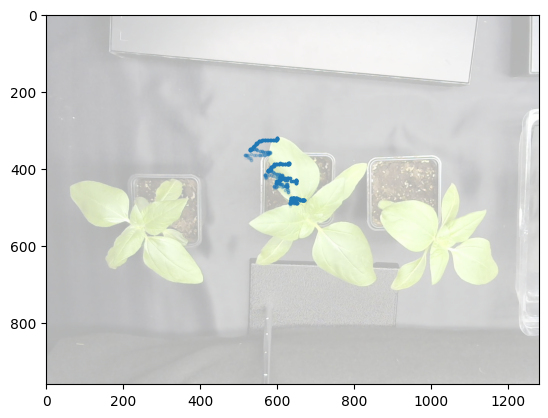

In [106]:
cmap = plt.get_cmap('tab20')

plt.imshow(labels[-1].image, alpha=0.3)

for i, frame in enumerate(labels):
    instance_coords = [x.numpy() for x in frame.instances]
    instance_coord = instance_coords[0]
    plt.scatter(instance_coord[:,0], instance_coord[:,1], s=3, color=cmap(0), alpha=i/len(labels))

特定のキーポイントのみ描画したい場合は

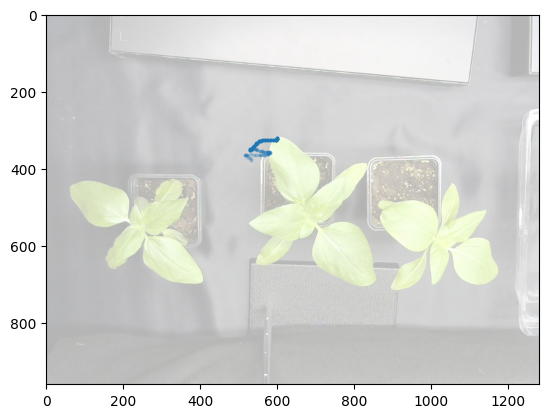

In [112]:
cmap = plt.get_cmap('tab20')

plt.imshow(labels[-1].image, alpha=0.3)

for i, frame in enumerate(labels):
    instance_coords = [x.numpy() for x in frame.instances]
    instance_coord = instance_coords[0]
    coord = instance_coord[-1]
    plt.scatter(coord[0], coord[1], s=3, color=cmap(0), alpha=i/len(labels))

## 最後に
ここまでノートブックをたどってきた人であれば、numpy arrayから（例えばpandasのデータフレームを経由して）csvファイルに座標をエクスポートするなど容易でしょう。
植物ではまだ動態解析の事例については限定的ですが、動物分野における知見が積極的に活用されはじめています。自身のデータで解析をぜひ行ってみましょう。